***
# <font color=red> Diagnosis of Malignant Breast Tissues by Using Machine Learning Algorithms</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure [May 2022]. Contact Alireza Dibazar for questions. </font></p>

***

## Overview:
This notebook provides a sample Breast Tissues classification technique using OCI's data science tools.

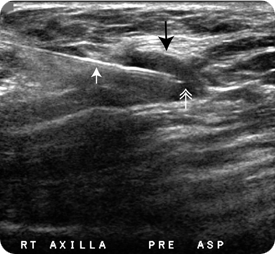
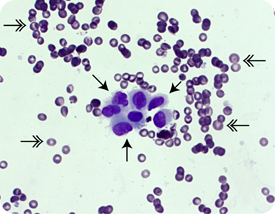
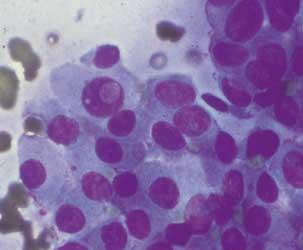

Using ultrasound guidance, a fine needle (small single arrows in the left picture) is placed in the center of the lump (large arrow) to be sampled. With the tip (double arrow) in the center of the lump, the needle is moved back and forth as aspiration is applied. The material obtained is smeared on a glass slide, stained and looked at under the microscope by a cytopathologist with specialty training in evaluating cells.


This notebook demonstrates simple steps for training a model to identify malignant samples, and deploying it to production.

---

## Contents:

* <a href='#intro'>Introduction</a>
    * <a href="#intro_dataset">Dataset</a>
    * <a href="#Data_Distribution">Data Distribution</a>
    * <a href="#Resample_data">Balanced Dataset</a>
    * <a href="#create_pipeline">Create Pileline Model and Fit</a>
* <a href='#create'>Create an Sklearn Model</a>
    * <a href="#compare_different_models">Compare Model performances</a>
* <a href='#serialize'>Sklearn Framework Serialization</a>
    * <a href='#serialize_sklearnmodel'>Create a SklearnModel</a>
    * <a href='#serialize_prepare'>Prepare</a>
    * <a href='#serialize_verify'>Verify</a>
    * <a href='#serialize_save'>Save</a>
    * <a href='#serialize_deploy'>Deploy</a>
    * <a href='#serialize_predict'>Predict</a>
* <a href='#req_resp'>Invoking the Endpoint</a>    
* <a href='#clean_up'>Clean Up</a>
* <a href='#ref'>References</a>    

---

**Important:**

Some field require replacement. They are surrounded with `<>`. For example `database_name = "<database_name>"` would become `database_name = "production"`.

---

<font color="gray">
Datasets are provided as a convenience. Datasets are considered third-party content and are not considered materials under your agreement with Oracle.
   
The dataset known as the Wisconsin Diagnosis Breast Cancer Dataset is from: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
    
More information and License can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)
    
</font>

This Notebook has been tested with the `generalml_p37_cpu_v1` conda environment.

In [2]:
# Update packages. -q make it silent.
! pip install -U oci-cli==3.10.3 -q
! pip install -U oracle-ads==2.6.1 -q

In [13]:
import ads
import io
import logging
import matplotlib.pyplot as plt
import numpy as np
import oci
import os
import pandas as pd
import re
import requests
import seaborn as sns
import tempfile
import warnings

from ads.automl.driver import AutoML
from ads.model.framework.automl_model import AutoMLModel
from ads.automl.provider import OracleAutoMLProvider
from ads.catalog.model import ModelCatalog
from ads.common.data import ADSData
from ads.common.model_metadata import UseCaseType
from ads.dataset.classification_dataset import BinaryClassificationDataset
from ads.dataset.factory import DatasetFactory
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_whatif_explainer import MLXWhatIfExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from lightgbm import LGBMClassifier

from shutil import rmtree

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, get_scorer, plot_confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.optimizers import Adam

# from sklearn.preprocessing import LabelBinarizer
# from mlxtend.plotting import plot_confusion_matrix

from xgboost import XGBClassifier

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
warnings.filterwarnings('ignore')

In [2]:
ads.__version__

'2.6.2'

<a id='intro'></a>
# Introduction
Breast Cancer

Core needle biopsy is the procedure to remove a small amount of suspicious tissue from the breast with a larger “core” (meaning “hollow”) needle. It is usually performed while the patient is under local anesthesia, meaning the breast is numbed. During the procedure, the doctor may insert a very small marker inside the breast to mark the location of the biopsy. If surgery is later required, the marker makes it easier for the surgeon to locate the abnormal area. Even if no further treatment such as surgery is needed, the marker allows a breast imaging radiologist to see on future mammograms where the biopsy was done.


Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass and they describe characteristics of the cell nuclei present in the image.

A benign tumor has distinct, smooth, regular borders and a malignant tumor has irregular borders and grows faster than a benign tumor. 

Binary classification is a technique of classifying records/elements of a given dataset into two groups on the basis of classification rules for ex: Breast Cell type idendification whether the individual's breast cells is Malignant or Not.

<a id="intro_dataset"></a>
## Dataset

This dataset contains 569 records of features extracted from breast cells. Based on the morphological characteristics of the cells the following major features are extracted and provided in the dataset:
    
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness: local variation in radius lengths
    - compactness which is calculated by perimeter^2 / area 
    - concavity which is defined by severity of concave portions of the contour
    - concave points (number of concave portions of the contour)
    - fractal dimension
    - Symmetry

The cells were then classified by experts physicians into two classes

    *    M. Malignant
    *    B. Benign


In the following cell, the data will be downloaded and read into a pandas Dataframe.


In [3]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

column_names = [
    "id", "diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean",
    "symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se",
    "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se",
    "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst",
    "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst",
    "concave points_worst", "symmetry_worst", "fractal_dimension_worst",
]

data_file_path = 'breast_cancer.csv'

df = pd.read_csv(data_url, header=None, names=column_names, index_col=0)
df.to_csv(data_file_path)

label_col = 'diagnosis'

# Exploratory Data Analysis

First, the dataframe is converted into an `ADSDataset` object, which provides simple ways to describe and visualize the data.

By setting the target (label class) and defining the positive class, the `ADSDataset` determines that this is a dataset for binary classification.

In [4]:
ds = DatasetFactory.from_dataframe(df)
ds = ds.set_target(label_col).set_positive_class('M')
ds

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

BinaryClassificationDataset(target: diagnosis) 569 rows, 31 columns

The Oracle ADS package provides a comprehensive view of the dataset, visualization of features and correlation.

In [5]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>569 Rows, 31 Columns</h3><h4>Col…

The recommendation tool suggests features to select (or drop) and offers to rebalance classes. In the next cell, use the default selection for the feature selection. 

For the Positive label, choose `M` for the Malignant samples.

The classes are not very imbalanced, so select `Do Nothing` to keep the dataset as-is without resampling.

In [6]:
ds.get_recommendations()

Output()

Once the recommendation are applied, get the transformed dataset, and have a look at the left over columns

In [7]:
ds2 = ds.get_transformed_dataset()
ds2.columns

Index(['diagnosis', 'symmetry_mean', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'texture_worst', 'smoothness_worst', 'compactness_worst',
       'concave_points_worst', 'symmetry_worst'],
      dtype='object')

## Pair Plots

Next, you can look at how each pair of the selected features discriminates the positive class using a pair plot.

The diagonal of the pair plot gives the distribution of each class for the single feature, while the scatter plots show the relationships between 2 features. The separation of dot clusters gives an indication that the class can indeed be identified using these features. 

Only the first 5 columns are shown here for readability. Adjust as you see fit.

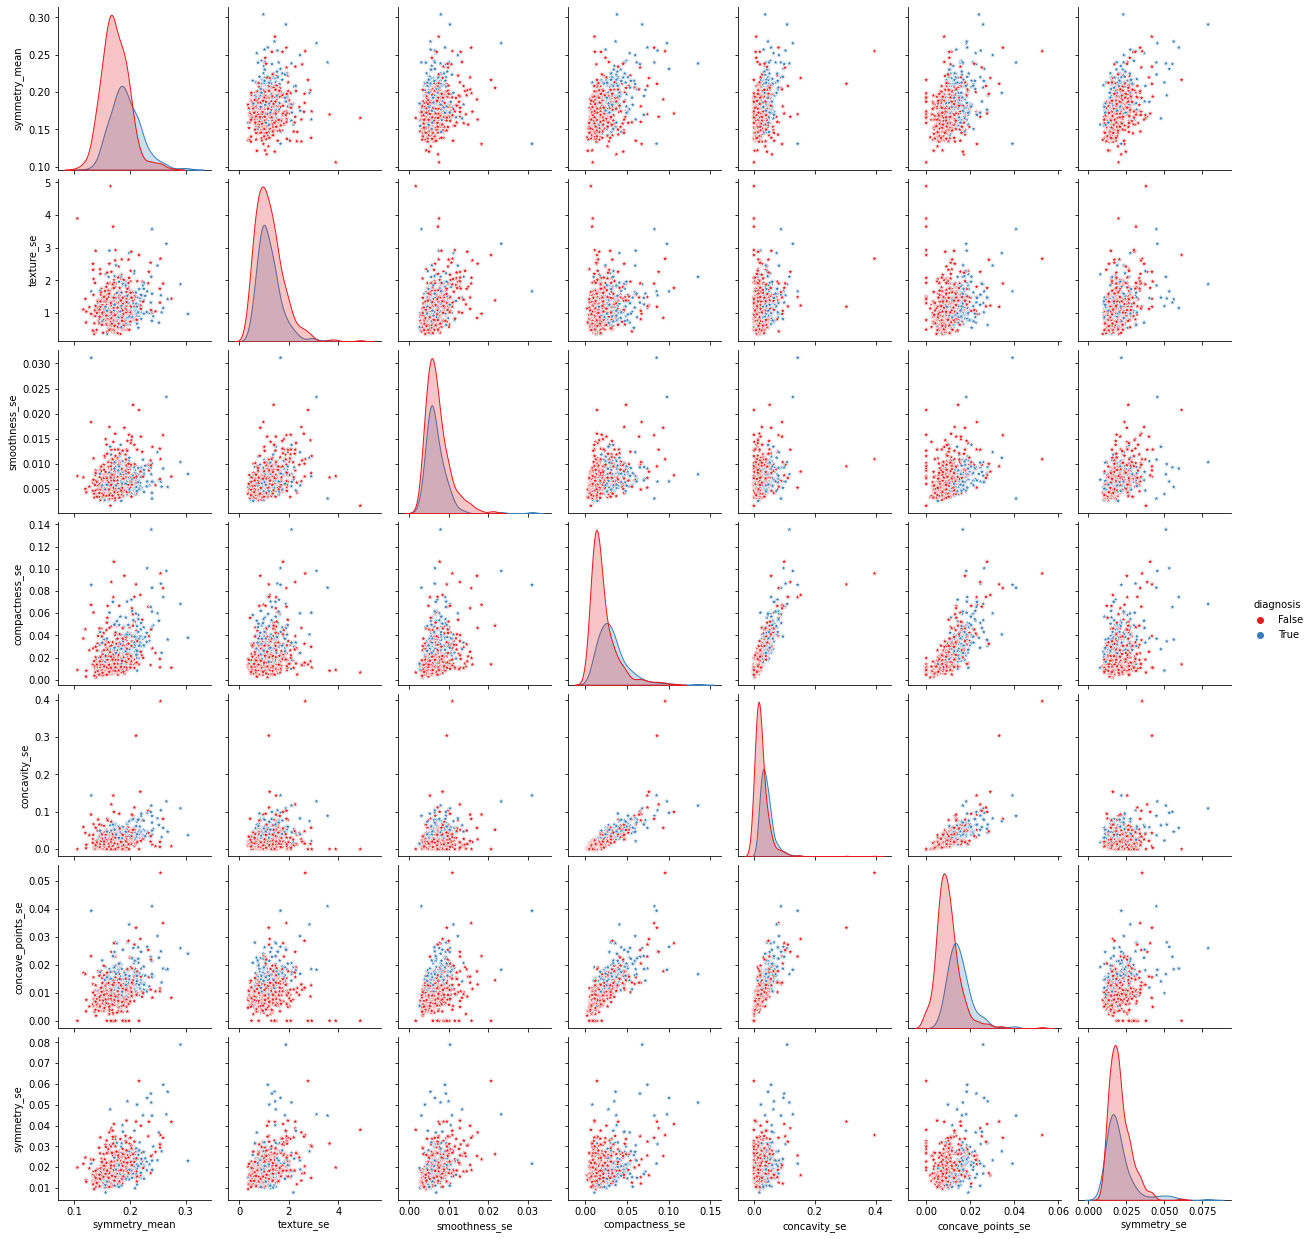

In [8]:
sns.pairplot(ds2.df, vars=ds2.columns[1:8], palette="Set1", hue=label_col, markers='*')
plt.show()

## Normalize the Dataset

Normalizing the data makes it easier to visualize relative influence of the features. Note the dataframe is normalized in the following cells, but the dataset is not recreated, so it stays unscaled and the models are later trained on unscaled data.

In [78]:
# normalize dataset
scaler = StandardScaler()
scaled_ds = scaler.fit_transform(ds2.drop(columns=[label_col]))
df2 = pd.DataFrame(scaled_ds, columns=ds2.drop(columns=[label_col]).columns, index=ds2.index)
df2[label_col] = ds2[label_col]

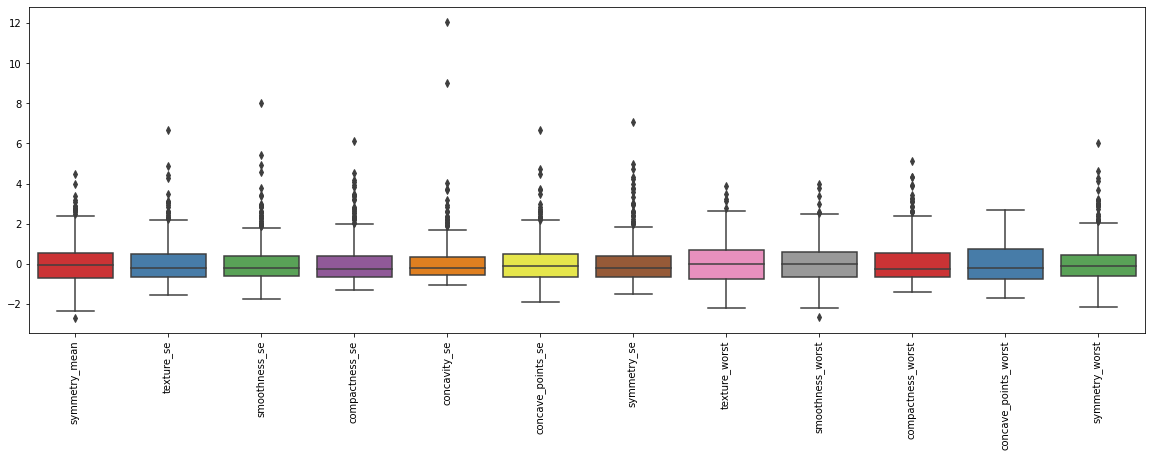

In [79]:
plt.figure(figsize=(20,6))
sns.boxplot(data = df2.drop(columns=label_col),palette = "Set1")
plt.xticks(rotation=90)
plt.show()

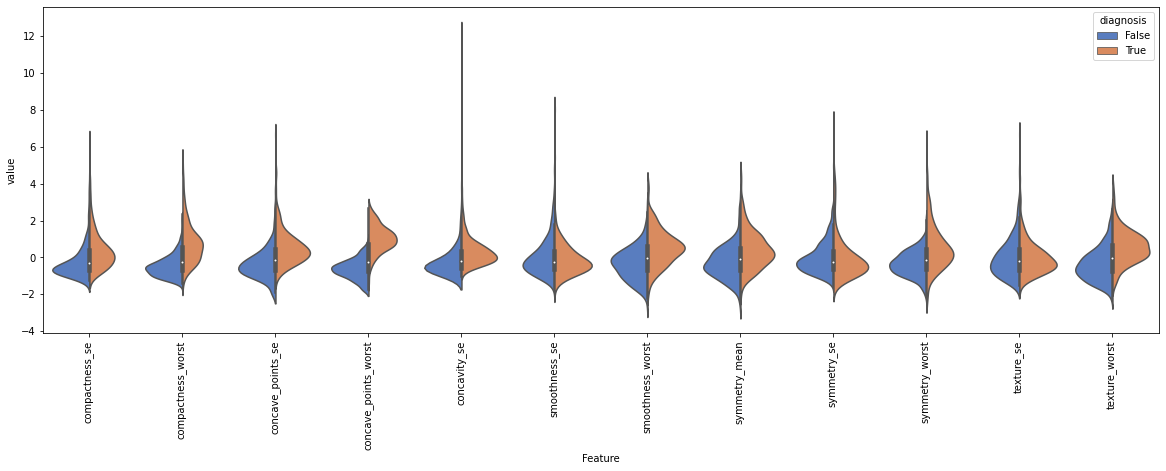

In [80]:
plt.figure(figsize=(20,6))
p = sns.violinplot(x='level_1',
               y=0,
               hue=label_col,
               data=df2.set_index([label_col]).stack().reset_index().sort_values('level_1'), 
               palette="muted", 
               split=True,
               y_label="value"
              )
p.set_xlabel('Feature')
p.set_ylabel('value')
plt.xticks(rotation=90)
plt.show()

<a id='create'></a>
# Model Selection

## Train and Test Datasets

The ADSDataset `train_test_split` method easily splits the dataset into a `train` set and a `test` set. In the next cell, a 20% split ratio was used. 

The target variable was already identified when creating the dataset with the `set_target` method, so each subset has a `X` (features) and `y` (target) property

In [49]:
train, test = ds2.train_test_split(0.2, random_state=0)

X_train = train.X
y_train = train.y
X_test = test.X
y_test = test.y

<a id='compare_different_models'></a>
## Compare Model performances



In [50]:
model_accuracy = pd.DataFrame(columns=['Model','Accuracy'])
models = {
          "LGBMClassifier" : LGBMClassifier(objective='binary', max_depth=3,),
          "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=3),
          'RandomForestClassifier' : RandomForestClassifier(max_depth=3),
          'GradientBoostingClassifier' : GradientBoostingClassifier(max_depth=3),
          'XGBClassifier' : XGBClassifier(max_depth=3),
          'SupportVectorClassifier' : SVC(kernel='linear')
          }

for model_name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print(f"{model_name} scores")
    print(f"Accuracy: {acc}")
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    
    model_accuracy = model_accuracy.append({'Model': model_name, 'Accuracy': acc, 'Train_acc': train_acc}, ignore_index=True)    
    print('*' * 100,"\n")

model_accuracy.sort_values(ascending=False, by='Accuracy')

LGBMClassifier scores
Accuracy: 0.9385964912280702
Classification Report
              precision    recall  f1-score   support

       False       0.92      0.99      0.95        67
        True       0.98      0.87      0.92        47

    accuracy                           0.94       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114

Confusion Matrix
[[66  1]
 [ 6 41]]
**************************************************************************************************** 

KNeighborsClassifier scores
Accuracy: 0.6754385964912281
Classification Report
              precision    recall  f1-score   support

       False       0.70      0.78      0.74        67
        True       0.62      0.53      0.57        47

    accuracy                           0.68       114
   macro avg       0.66      0.65      0.66       114
weighted avg       0.67      0.68      0.67       114

Confusion Matrix
[[52 15]
 [22 25]]
*******************

Model  Accuracy  Train_acc
0              LGBMClassifier  0.938596   0.997802
5               XGBClassifier  0.938596   1.000000
2      DecisionTreeClassifier  0.921053   0.947253
4  GradientBoostingClassifier  0.921053   1.000000
3      RandomForestClassifier  0.912281   0.934066
6     SupportVectorClassifier  0.833333   0.876923
1        KNeighborsClassifier  0.675439   0.870330

The model found to be best is the LGBMClassifier which ends up with 93.8% testing accuracy. 

The AutoML module performs more advanced optimizations, with hyper-parameters tuning. The next section covers using AutoML.

<a id="ads_automl"></a>
## Model Selection with ADS AutoML


<a id='automl_setup'></a>
### AutoML setup

Next the AutoML package is used to define an experiment and try out several models. 
The full list of available models is used (i.e. same as default). The `time_budget` define how much time should be spent looking for the best model.

AutoML also takes multiple providers. `OracleAutoMLProvider is only available within OCI Notebook sessions.

AutoML performs feature selection, hyper-parameter tuning and model selection.

In [51]:
automl = AutoML(train, provider=OracleAutoMLProvider())
model, baseline = automl.train(model_list=[
    'AdaBoostClassifier',
    'DecisionTreeClassifier',
    'ExtraTreesClassifier',
    'KNeighborsClassifier',
    'LGBMClassifier',
    'LinearSVC',
    'LogisticRegression',
    'RandomForestClassifier',
    'SVC',
    'XGBClassifier'
], score_metric="roc_auc", time_budget=600)

INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped


The `visualize_algorithm_selection_trials` method shows how algorithms are seleted.

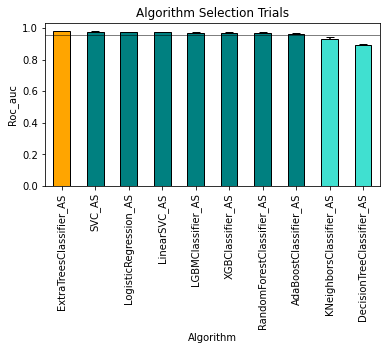

In [52]:
automl.visualize_algorithm_selection_trials()

The `visualize_feature_selection_trials` method visualizes how the number of features is selected for a minimal number of features and best performance metric.


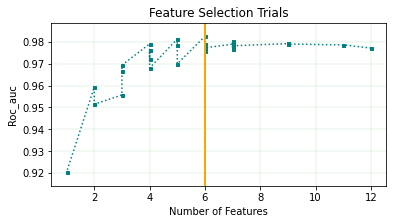

In [53]:
automl.visualize_feature_selection_trials()

The `visualize_tuning_trials` method shows how the evaluation metric improved with iterations.

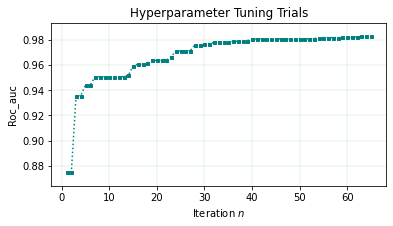

In [54]:
automl.visualize_tuning_trials()

Evaluate the actual accuracy on test data:

In [55]:
accuracy_scorer = get_scorer("accuracy") 
print("Oracle AutoML model accuracy on test data:", model.score(test.X, test.y, score_fn=accuracy_scorer))

Oracle AutoML model accuracy on test data: 0.956140350877193


In [56]:
model.predict(test.X[:10])

array([ True, False, False, False, False, False, False, False, False,
       False])

In [57]:
test.y[:10]

id
915691      True
9112367    False
909410     False
892214     False
854941     False
916221     False
90250      False
893783     False
921092     False
898677     False
Name: diagnosis, dtype: bool

In [58]:
print(model)

Framework: sklearn.ensemble._forest
Estimator class: ExtraTreesClassifier
Model Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.777777778, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 253, 'n_jobs': 1, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}



<a id="explain"></a>
# Explaining the Model

In this section, the ADS Explainer package is used to look at the model behavior and sensitivity to variation in given features.

<a id="whatlearned"></a>
## Show what the model has learned

It is great to have an expert with knowledge of what a model should do. However, this is often not available. Models sometimes learn different things than what an expert would speculate. Generally, models learn important relationships between the features. For many machine learning models, it is difficult to understand what the model has learned. 

The `ADSExplainer` provides a powerful set of tools that provide the data scientist insight into what the model is doing. It does this by building other models and performing simulations on the model's predictions. From this, the `ADSExplainer` learns what has been learned. 

When an explanation does not make sense, it does not mean the explanation is wrong. It is possible that the model has learned new relationships in the data. This shows how `MLX` can be used to understand and debug the modeling process.

In [83]:
explainer = ADSExplainer(test, model)

<a id='global'></a>
## Global Explanations

Generating global explanations for the model:

Using the `ADSExplainer` object, the `global_explanation` method creates a generator for global model explanations. Oracle Labs global `MLX` is selected as the provider using the `MLXGlobalExplainer` object. Global explanation supports both feature importance explanations and feature dependence explanations, such as Partial Dependence Plots (PDP) and Individual Conditional Expectations (ICE). 

First, look at feature importance, which provides a list of features sorted by their ability to influence the predictions.

In [84]:
global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())
importances = global_explainer.compute_feature_importance()
importances.show_in_notebook(n_features=10)

MLXProgBar:   0%|          | 0/20 [00:00<?, ?it/s]

MLXProgBar:   0%|          | 0/3 [00:00<?, ?it/s]

concave_points_worst, texture_worst and compactness_worst are the most important features for this model.


The `detailed` mode provides scatter plot which shows the distribution of the importance measure and provides a sense of the variation in the data. The top 10 features are plotted.

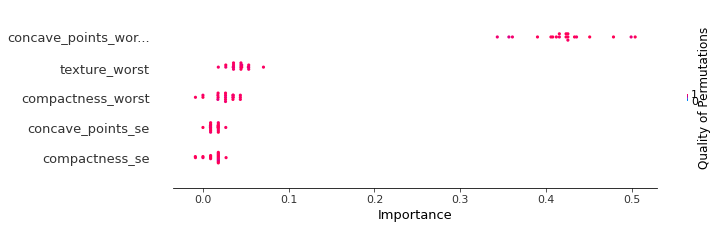

In [85]:
importances.show_in_notebook(n_features=5, mode='detailed')

<a id="feat_dep_exp"></a>
### Feature Dependence Explanations (PDP & ICE)

Next, visualize how different values for the important features interact with the target variable. This is done through Partial Dependence Plots (PDP) and Individual Conditional Expectations (ICE) explanations. 

The following cell shows how to learn more about the PDP and ICE techniques used in the `MLXGlobalExplainer`. This provides a description of the algorithm and how to interpret the output. 

In [86]:
global_explainer.partial_dependence_summary()

Look at the top most important features to see the distribution of its values and the outcome on the prediction P(1)

In [88]:
explanation = explainer.global_explanation().compute_partial_dependence("concave_points_worst")
explanation.show_in_notebook(mode="pdp", labels=[1])

MLXProgBar:   0%|          | 0/29 [00:00<?, ?it/s]

In [89]:
explanation.show_in_notebook(mode="ice", centered=False, 
                              show_distribution=True, 
                              show_correlation_warning=True, 
                              show_median=True,
                              labels=[1])

Next, look at the dependence of variables `concave_points_worst` and `texture_worst` to see in what combination of variables the model 

In [90]:
otjl_explanation = explainer.global_explanation().compute_partial_dependence(['concave_points_worst', 'texture_worst'])
otjl_explanation.show_in_notebook(show_distribution=True, show_correlation_warning=False, line_gap=1)

MLXProgBar:   0%|          | 0/870 [00:00<?, ?it/s]

<a id="whatif"></a>
## What-if Scenarios 

Using the `ADSExplainer` object, "WhatIf" explanation object can be created to generate model explanations. Oracle Labs WhatIf `MLX` is selected as the provider using the `MLXWhatIfExplainer` object. WhatIf explanation supports both explore sample and explore predictions.

In [91]:
whatif_explainer = explainer.whatif_explanation(provider=MLXWhatIfExplainer())

### Predictions Explorer

The predictions Explorer tool allows you to explore model predictions across either the marginal distribution (1-feature) or the joint distribution (2-feature) of the features in your train/validation/test dataset. The method `explore_predictions()` has several optional parameters including: 

* `feature`: the name of the feature to visualize 
* `label`: either the target label index or name to visualize 
* `plot_type`: `scatter`, `bar`, `box`.
* `discretization`: method to discretize continuous features (Options are no discretization, quartile, decile, or percentile)

Try the top features and observe that the Positive predictions are well discriminated with these features.

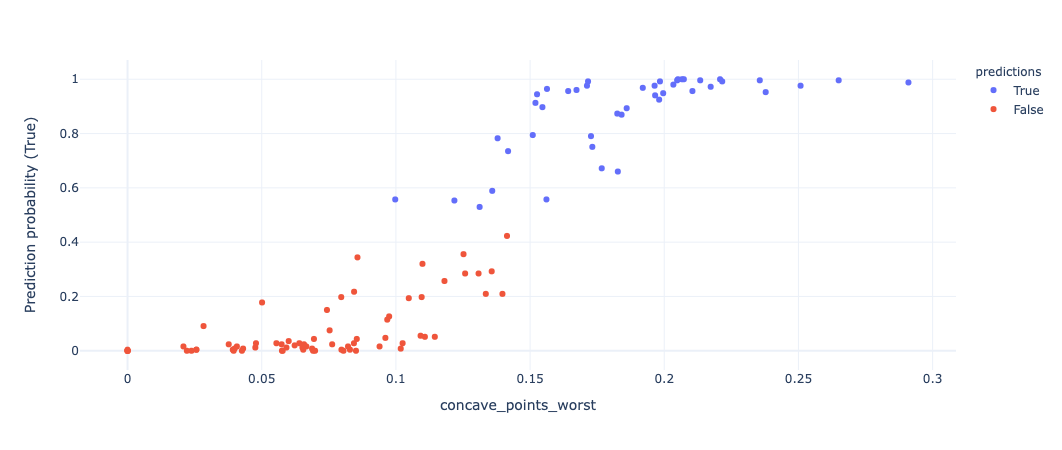

In [99]:
whatif_explainer.explore_predictions('concave_points_worst')
# whatif_explainer.explore_predictions('texture_worst')
# whatif_explainer.explore_predictions('compactness_worst')

<a id='localexplanations'></a>
## Local Explanations

Global explanations inform the data scientist about the general trends in a model. They do not describe what is happening with a specific prediction. That is the role of local explanations. They are model-agnostic and provide insights into why a model made a specific prediction.  

The explainer provides useful insight on the direction each feature has influenced the final prediction.

In [100]:
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
local_explainer = explainer.local_explanation(provider=MLXLocalExplainer())

sample = 10
(X, y) = test.X.iloc[[sample]], test.y.iloc[[sample]]

local_explainer.explain(X, y).show_in_notebook(labels=1)

MLXProgBar:   0%|          | 0/1 [00:00<?, ?it/s]

<a id='serialize'></a>
# Model Deployment

The model is trained and working well. The next step is to make it available to the world to infer on unknown samples.

ADS model.framework makes it easy to deploy a model into production. It supports several types of models, including `AutoML`, `LightGBM`, `PyTorch`, `Sklearn`, `TensorFlow`, and `XGBoost` models. The constructor takes a model and converts it into an ADS object meant for model serialization and deployment. 

Deploying the model into production requires a few steps: `prepare` the model artifact, creating a bundle of files inference code, and metadata about the input and output schemas, the model provenance and environment where it was trained. `verify` the artifact, by testing the generated inference code locally. `save` the model to the model catalog, and then `deploy`. Once deployed, using the `predict` method calls the deployment endpoint to infere from the deployed model.

ADS provides the `.summary_status()` method that outputs a dataframe that defines the steps, status, and detailed information about each step. 

<a id='serialize_sklearnmodel'></a>
## Create a Serialized Model

The AutoML model created previously model is the model to deploy.

The `AutoMLModel()` constructor takes an AutoML model along with the path where to store the model artifacts. An `AutoMLModel` object is returned, and it is used to manage the deployment.

The next cell creates a temporary model artifact directory, sets the authentication to use resource principal (required to check on deployment status), and creates the `AutoMLModel` object.

In [101]:
artifact_dir = tempfile.mkdtemp()
ads.set_auth(auth='resource_principal')
automl_model = AutoMLModel(estimator=model, artifact_dir=artifact_dir)

The `.summary_status()` method of the `AutoMLModel` class is a handy method to keep track of the progress that you are making in deploying the model. It creates a dataframe that lists the deployment steps, thier status, and details about them. The next cell returns the summary status dataframe. It shows that the initiate step has been completed.

In [102]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Available     Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Not Available Local tested .predict from score.py                               
save()    Not Available Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_prepare'></a>
## Prepare the Model Artifacts

The prepare step is performed by the `.prepare()` method of the `AutoMLModel` class. It creates a number of customized files that are used to run the model once it is deployed. These include:

* `input_schema.json`: A JSON file that defines the nature of the features of the `X_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `model.joblib`: This is the default filename of the serialized model. It can be changed with the `model_file_name` attribute. By default, the model is stored in a joblib file. The parameter `as_onnx` can be used to save it in the ONNX format.
* `output_schema.json`: A JSON file that defines the nature of the dependent variable in the `y_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `runtime.yaml`: This file contains information that is needed to set up the runtime environment on the deployment server. It has information about which conda environment was used to train the model, and what environment should be used to deploy the model. The file also specifies what version of Python should be used.
* `score.py`: This script contains the `load_model()` and `predict()` functions. The `load_model()` function understands the format the model file was saved in and loads it into memory. The `.predict()` method is used to make inferences in a deployed model. There are also hooks that allow you to perform operations before and after inference. You can modify this script to fit your specific needs.

To create the model artifacts, you use the `.prepare()` method. There are a number of parameters that allow you to store model provenance information. In the next cell, the `conda_env` variable defines the slug of the conda environment that was used to train the model, and also the conda environment that should be used for deployment. Note that you can only pass in slugs to `inference_conda_env` or `training_conda_env` if it's a service environment. Otherwise, you must pass in the full path of the conda envvironment along with the python version through `inference_python_version` and `training_python_version`.

In [103]:
conda_env = 'generalml_p37_cpu_v1'

automl_model.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    X_sample=X_test,
    y_sample=y_test,
)

The next cell uses the `.summary_status()` method to show you that the prepare step finished, and what tasks were completed.

In [104]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

The `.prepare()` method has created the following files. These files are fully functional. However, you can modify them to fit your specific needs.

In [105]:
os.listdir(artifact_dir)

['input_schema.json',
 'score.py',
 'model.pkl',
 'runtime.yaml',
 'output_schema.json']

Once the artifacts have been created, there are a number of attributes in the `AutoMLModel` object that provides metadata about the model. The `.runtime` attribute details the model deployment settings and model provenance data.

In [106]:
automl_model.runtime_info

model_artifact_version: '3.0'
model_deployment:
  inference_conda_env:
    inference_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
    inference_env_slug: generalml_p37_cpu_v1
    inference_env_type: data_science
    inference_python_version: '3.7'
model_provenance:
  project_ocid: ''
  tenancy_ocid: ''
  training_code:
    artifact_directory: /tmp/tmpolp9rpxv
  training_compartment_ocid: ''
  training_conda_env:
    training_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
    training_env_slug: generalml_p37_cpu_v1
    training_env_type: data_science
    training_python_version: '3.7'
  training_region: ''
  training_resource_ocid: ''
  user_ocid: ''
  vm_image_internal_id: ''

The `.schema_input` attribute provides metadata on the features that were used to train the model. You can use this information to determine what data must be provided to make model inferences. Each feature in the model has a section that defines the dtype, feature type, name, and if it is required. The metadata also includes the summary statistics associated with the feature type.

In [107]:
automl_model.schema_input

schema:
- description: smoothness_se
  domain:
    constraints: []
    stats:
      count: 114.0
      lower quartile: 0.005
      mean: 0.007
      median: 0.006
      sample maximum: 0.031
      sample minimum: 0.003
      skew: 3.306
      standard deviation: 0.004
      upper quartile: 0.008
    values: Continuous
  dtype: float64
  feature_type: Continuous
  name: smoothness_se
  order: 2
  required: true
- description: concavity_se
  domain:
    constraints: []
    stats:
      count: 114.0
      lower quartile: 0.014
      mean: 0.034
      median: 0.028
      sample maximum: 0.144
      sample minimum: 0.0
      skew: 1.402
      standard deviation: 0.026
      upper quartile: 0.047
    values: Continuous
  dtype: float64
  feature_type: Continuous
  name: concavity_se
  order: 4
  required: true
- description: compactness_se
  domain:
    constraints: []
    stats:
      count: 114.0
      lower quartile: 0.013
      mean: 0.027
      median: 0.021
      sample maximum: 0.094


The `.metadata_custom` attribute provides custom metadata that contains information on the category of the metadata, description, key, and value.

In [108]:
automl_model.metadata_custom

data:
- category: Training Environment
  description: The URI of the training conda environment.
  key: CondaEnvironmentPath
  value: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
- category: Training Environment
  description: The conda environment type, can be published or datascience.
  key: EnvironmentType
  value: data_science
- category: Training Profile
  description: The model serialization format.
  key: ModelSerializationFormat
  value: pkl
- category: Other
  description: ''
  key: ClientLibrary
  value: ADS
- category: Training Environment
  description: The list of files located in artifacts folder.
  key: ModelArtifacts
  value: score.py, model.pkl, runtime.yaml
- category: Training Environment
  description: The slug name of the training conda environment.
  key: SlugName
  value: generalml_p37_cpu_v1
- category: Training Environment
  description: The conda environment where the model was

The `.metadata_provenance` contains information about the code and training data that was used to create the model. This information is most useful when a Git repository is being used to manage the code for training the model. This is considered a best practice because it allows you to do things like reproduce a model, perform forensic on the model, and so on.

In [109]:
automl_model.metadata_provenance

artifact_dir: null
git_branch: null
git_commit: null
repo: null
repository_url: null
training_id: null
training_script_path: null

The `.metadata_taxonomy` is a key-value store that has information about the classification or taxonomy of the model. This can include information such as the model framework, use case type, hyperparameters, and more.

In [110]:
automl_model.metadata_taxonomy

data:
- key: Hyperparameters
  value: null
- key: Algorithm
  value: ensemble
- key: UseCaseType
  value: binary_classification
- key: FrameworkVersion
  value: '1.0'
- key: Framework
  value: oracle_automl
- key: ArtifactTestResults
  value: null

<a id='serialize_verify'></a>
## Verify: Test the Model Locally

If you modify the `score.py` file that is part of the model artifacts, then you should verify it. The verify step allows you to test those changes without having to deploy the model. This allows you to debug your code without having to save the model to the model catalog and then deploy it. The `.verify()` method takes a set of test parameters and performs the prediction by calling the `predict` function in `score.py`. It also runs the `load_model` function.

The next cell simulates a call to a deployed model without having to actually deploy the model. It passes in test values and returns the predictions.

In [111]:
df[15:25]

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                                         
84799002         M       14.540         27.54           96.73      658.8   
848406           M       14.680         20.13           94.74      684.5   
84862001         M       16.130         20.68          108.10      798.8   
849014           M       19.810         22.15          130.00     1260.0   
8510426          B       13.540         14.36           87.46      566.3   
8510653          B       13.080         15.71           85.63      520.0   
8510824          B        9.504         12.44           60.34      273.9   
8511133          M       15.340         14.26          102.50      704.4   
851509           M       21.160         23.04          137.20     1404.0   
852552           M       16.650         21.38          110.00      904.6   

          smoothness_mean  compactness_mean  concavity_mean  \
id                                                            
84799002          0.11390           0.15950         0.16390   
848406            0.09867           0.07200         0.07395   
84862001          0.11700           0.20220         0.17220   
849014            0.09831           0.10270         0.14790   
8510426           0.09779           0.08129         0.06664   
8510653           0.10750           0.12700         0.04568   
8510824           0.10240           0.06492         0.02956   
8511133           0.10730           0.21350         0.20770   
851509            0.09428           0.10220         0.10970   
852552            0.11210           0.14570         0.15250   

          concave_points_mean  symmetry_mean  ...  radius_worst  \
id                                            ...                 
84799002              0.07364         0.2303  ...         17.46   
848406                0.05259         0.1586  ...         19.07   
84862001              0.10280         0.2164  ...         20.96   
849014                0.09498         0.1582  ...         27.32   
8510426               0.04781         0.1885  ...         15.11   
8510653               0.03110         0.1967  ...         14.50   
8510824               0.02076         0.1815  ...         10.23   
8511133               0.09756         0.2521  ...         18.07   
851509                0.08632         0.1769  ...         29.17   
852552                0.09170         0.1995  ...         26.46   

          texture_worst  perimeter_worst  area_worst  smoothness_worst  \
id                                                                       
84799002          37.13           124.10       943.2            0.1678   
848406            30.88           123.40      1138.0            0.1464   
84862001          31.48           136.80      1315.0            0.1789   
849014            30.88           186.80      2398.0            0.1512   
8510426           19.26            99.70       711.2            0.1440   
8510653           20.49            96.09       630.5            0.1312   
8510824           15.66            65.13       314.9            0.1324   
8511133           19.08           125.10       980.9            0.1390   
851509            35.59           188.00      2615.0            0.1401   
852552            31.56           177.00      2215.0            0.1805   

          compactness_worst  concavity_worst  concave_points_worst  \
id                                                                   
84799002             0.6577          0.70260               0.17120   
848406               0.1871          0.29140               0.16090   
84862001             0.4233          0.47840               0.20730   
849014               0.3150          0.53720               0.23880   
8510426              0.1773          0.23900               0.12880   
8510653              0.2776          0.18900               0.07283   
8510824              0.1148          0.08867               0.06227   
8511133        

In [112]:
feature_columns = [f['name'] for f in sorted(automl_model.schema_input.to_dict().get('schema'), key=lambda x: x['order'])]
automl_model.verify(df[15:25][feature_columns])

INFO:xengine:All work stopped
INFO:xengine:All work stopped
Start loading model.pkl from model directory /tmp/tmpolp9rpxv ...
Model is successfully loaded.


{'prediction': [True, True, True, True, False, False, False, True, True, True]}

The `.summary_status()` method is updated to show that the verify step has been completed.

In [113]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_save'></a>
## Save the Model in the Model Catalog

Once you are satisfied with the performance of the model and have verified that the `score.py` file is working, you can save the model to the model catalog. You do this with the `.save()` method on a `AutoMLModel` object. This bundles up the model artifact that you have created, and push it to the model catalog. It returns the model OCID. It's important to keep track of this id, as it is used to delete the model later.

In [75]:
model_id = automl_model.save(display_name='breast_cancer_demo')

INFO:xengine:All work stopped
INFO:xengine:All work stopped
Start loading model.pkl from model directory /tmp/tmp6v_7mzk7 ...
Model is successfully loaded.
['input_schema.json', 'score.py', 'model.pkl', 'runtime.yaml', 'output_schema.json']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_04253fb5-0394-44b9-b895-a41869835375.zip


In [76]:
model_id

'ocid1.datasciencemodel.oc1.phx.amaaaaaanif7xwia3rgqw3pebzboj553wylcrersnfalm5zrgngvpq7s42hq'

<a id='serialize_deploy'></a>
## Deploy

With the model in the model catalog, you can use the `.deploy()` method to deploy the model. This method allows you to specify the attributes of the deployment such as the display name, description, instance type and count, the maximum bandwidth, and logging groups. The next cell deploys the model with the default settings, except for the custom display name. The `.deploy()` method returns a `ModelDeployment` object.

In [77]:
deployment = automl_model.deploy(display_name='breast_cancer_demo_model_deployment')

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

After deployment, the `.summary_status()` method shows that the model is ACTIVE and the `predict()` method is available.

In [179]:
automl_model.summary_status()

Actions Needed
Step      Status    Details                                                           
initiate  Done      Initiated the model                                               
prepare() Done      Generated runtime.yaml                                            
                    Generated score.py                                                
                    Serialized model                                                  
                    Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done      Local tested .predict from score.py                               
save()    Done      Conducted Introspect Test                                         
                    Uploaded artifact to model catalog                                
deploy()  ACTIVE    Deployed the model                                                
predict() Available Called deployment predict endpoint

<a id='serialize_predict'></a>
## Predict

Earlier you used the `model.predict()` method where `model` was an `ADSModel` object. This did inference using the local model. Now that the `XGBoostModel` model has been deploy, the `.predict()` method is available to do inference on the deployed model. It effectively calls the deployed model endpoint.


In [182]:
automl_model.predict(df[:2][feature_columns])

{'prediction': [1, 1]}

<a id='req_resp'></a>
## Invoking the REST Endpoint

To invoke the RESRT endpoint, JSON data needs to be passed to the HTTP call. The test data is created from raw data by selecting the appropriate columns and exporting to JSON with pandas `to_json` method.

Then a HTTP POST request is sent to the endpoint, and results are received as JSON.

In [185]:
input_data = df[:2][feature_columns].to_json(orient='records')
endpoint = f"{deployment.url}/predict"
auth = oci.auth.signers.get_resource_principals_signer()

requests.post(endpoint, json={'data': input_data, 'data_type':"pandas.core.frame.DataFrame"}, auth=auth).json()

{'prediction': [1, 1]}

<a id='clean_up'></a>
# Clean Up

This notebook created a model deployment and a model. This section cleans up those resources. 

The model deployment must be deleted before the model can be deleted. You use the `.delete_deployment()` method on the `SklearnModel` object to do this.

In [55]:
delete = automl_model.delete_deployment(wait_for_completion=True)

After the model deployment has been deleted, the `.summary_status()` method shows that the model has been deleted and that the `predict()` method is not available.

In [56]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  DELETED       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

Use the `.delete_model()` method in a `ModelCatalog` object to delete the model.

In [57]:
ModelCatalog(compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID']).delete_model(model_id)

True

The next cell removes the model artifacts that were stored on your local drive.

In [58]:
rmtree(artifact_dir)

<a id='ref'></a>
# References
- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
- [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)
- [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml)
- [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py)
- [Model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models)
- [ONNX API Summary](http://onnx.ai/sklearn-onnx/api_summary.html)